In [1]:
import dpkt # librería para procesar paquetes de red
import socket

def process_pcap(file_name):
    packets = []
    with open(file_name, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for ts, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            packet_info = {
                'File': file_name,
                'Time': ts,
                'Source': ':'.join(f"{b:02x}" for b in eth.src),
                'Destination': ':'.join(f"{b:02x}" for b in eth.dst),
                'Protocol': eth.data.__class__.__name__, #__name__ if hasattr(eth.data, 'data')
                #else eth.data.hex(),
                'Length': len(buf),
                'Info':  getattr(eth.data, 'summary', None),
            }
            packets.append(packet_info)
    return packets

# Ejemplo de uso
file_names = ['h1-traffic.pcap', 'h2-traffic.pcap']
combined_packets = []
for file_name in file_names:
    try:
        packets = process_pcap(file_name)
        combined_packets.extend(packets)
    except Exception as e:
        print(f"Error al procesar el archivo {file_name}: {str(e)}")

# Mostrar los primeros 5 paquetes para verificar
for idx, packet in enumerate(combined_packets[:26], 1):
    print(f"Paquete {idx}:")
    print(f"   File:        {packet['File']}")
    print(f"   Time:        {packet['Time']}")
    print(f"   Source:      {packet['Source']}")
    print(f"   Destination: {packet['Destination']}")
    print(f"   Protocol:    {packet['Protocol']}")
    print(f"   Length:      {packet['Length']}")
    print(f"   Info:        {packet['Info']}")
    print()  # línea en blanco entre paquetes



Paquete 1:
   File:        h1-traffic.pcap
   Time:        1718847010.587005
   Source:      ce:66:d5:6d:84:6e
   Destination: 33:33:00:00:00:16
   Protocol:    IP6
   Length:      90
   Info:        None

Paquete 2:
   File:        h1-traffic.pcap
   Time:        1718847010.878138
   Source:      a2:4b:5f:db:b8:92
   Destination: 33:33:ff:db:b8:92
   Protocol:    IP6
   Length:      86
   Info:        None

Paquete 3:
   File:        h1-traffic.pcap
   Time:        1718847010.943029
   Source:      5a:d7:bd:21:1c:d2
   Destination: 33:33:ff:21:1c:d2
   Protocol:    IP6
   Length:      86
   Info:        None

Paquete 4:
   File:        h1-traffic.pcap
   Time:        1718847010.983621
   Source:      5a:d7:bd:21:1c:d2
   Destination: 33:33:00:00:00:16
   Protocol:    IP6
   Length:      90
   Info:        None

Paquete 5:
   File:        h1-traffic.pcap
   Time:        1718847011.003485
   Source:      ce:66:d5:6d:84:6e
   Destination: 33:33:ff:6d:84:6e
   Protocol:    IP6
   Length: 

In [2]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos
import nest_asyncio # librería para permitir el uso de asyncio en entornos no asincrónicos
nest_asyncio.apply() # Permitir el uso de asyncio en entornos no asincrónicos



def format_mac_address(mac):
    # Función para formatear la dirección MAC
    if mac is None:
        return None
    # Verificar si ya es una cadena y no una secuencia de bytes
    if isinstance(mac, str):
        return mac  # Devolver tal cual si ya es una cadena
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    for pkt in cap:
        try:
            # Usar el campo 'eth.src' y 'eth.dst' directamente si están disponibles
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer  # Usar highest_layer en lugar de transport_layer para obtener el protocolo
            data.append([src_mac, dst_mac, protocol])
        except AttributeError:
            pass  # Ignorar paquetes sin atributos de MAC válidos
    cap.close()

    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol'])

# Función para mostrar datos en formato de tabla con formato específico y rango específico
def mostrar_datos_en_formato(data, desde, hasta):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        # Imprimir encabezados
        print(f"{'Source':<18} {'Destination':<18} Protocol")
        print("="*50)
        # Imprimir datos en el rango especificado
        for i, row in data.iloc[desde-1:hasta].iterrows():
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']}")

# Cargar características desde los archivos pcap
data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

# Definir el rango de filas a mostrar
desde = 25
hasta = 30

# Mostrar el rango especificado en formato de tabla
print(f"Datos cargados desde h1-traffic.pcap (filas {desde} a {hasta}):")
mostrar_datos_en_formato(data_h1, desde, hasta)

print(f"\nDatos cargados desde h2-traffic.pcap (filas {desde} a {hasta}):")
mostrar_datos_en_formato(data_h2, desde, hasta)



Datos cargados desde h1-traffic.pcap (filas 25 a 30):
Source             Destination        Protocol
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ARP
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ARP
a2:4b:5f:db:b8:92  33:33:00:00:00:02  ICMPV6
5a:d7:bd:21:1c:d2  33:33:00:00:00:02  ICMPV6
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP

Datos cargados desde h2-traffic.pcap (filas 25 a 30):
Source             Destination        Protocol
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ARP
a2:4b:5f:db:b8:92  33:33:00:00:00:02  ICMPV6
86:4f:2b:ac:d2:1e  33:33:00:00:00:02  ICMPV6
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP
ce:66:d5:6d:84:6e  33:33:00:00:00:02  ICMPV6


In [3]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos

def format_mac_address(mac):
    if mac is None:
        return None
    if isinstance(mac, str):
        return mac
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    for pkt in cap:
        try:
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer
            length = int(pkt.length)
            duration = float(pkt.frame_info.time_delta)
            data.append([src_mac, dst_mac, protocol, length, duration])
        except AttributeError:
            pass
    cap.close()
    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol', 'Length', 'Duration'])

def format_duration(duration):
    # Función para formatear la duración en segundos completos
    return f"{duration:.6f}"  # Mostrar la duración con 6 decimales

def mostrar_datos_en_formato(data, desde, hasta, etiquetas):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        print(f"{'Source':<18} {'Destination':<18} Protocol {'Length':<8} {'Duration (s)':<15} {'Label':<8}")
        print("="*90)
        for i, (index, row) in enumerate(data.iloc[desde-1:hasta].iterrows(), start=1):
            label = etiquetas[index]
            duration_seconds = format_duration(row['Duration'])
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']:<10} {row['Length']:<8} {duration_seconds:<15} {label}")

data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

print("Ejemplo de etiquetas verdaderas para h1-traffic.pcap:")
print(true_labels_h1[:25])

print("\nEjemplo de etiquetas verdaderas para h2-traffic.pcap:")
print(true_labels_h2[:25])

print("\nDatos cargados desde h1-traffic.pcap:")
mostrar_datos_en_formato(data_h1, 20, 25, true_labels_h1)

print("\nDatos cargados desde h2-traffic.pcap:")
mostrar_datos_en_formato(data_h2, 20, 25, true_labels_h2)



Ejemplo de etiquetas verdaderas para h1-traffic.pcap:
[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]

Ejemplo de etiquetas verdaderas para h2-traffic.pcap:
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Datos cargados desde h1-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Label   
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000045        0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.017914        1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000035        0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.038492        0
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000038        1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ARP        42       0.094680        0

Datos cargados desde h2-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Label   
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP 

In [4]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos
import nest_asyncio # librería para permitir el uso de asyncio en entornos no asincrónicos
nest_asyncio.apply() # Permitir el uso de asyncio en entornos no asincrónicos

def format_mac_address(mac):
    if mac is None:
        return None
    if isinstance(mac, str):
        return mac
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    packet_count = 0
    byte_count = 0
    connection_set = set()

    for pkt in cap:
        try:
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer
            length = int(pkt.length)
            duration = float(pkt.frame_info.time_delta)
            
            # Calculamos la cantidad de paquetes por segundo
            packet_count += 1
            packets_per_second = packet_count / duration if duration > 0 else 0
            
            # Contamos las conexiones únicas (por ejemplo, basado en direcciones IP)
            connection_set.add((src_mac, dst_mac))
            active_connections = len(connection_set)
            
            # Calculamos el ancho de banda utilizado (en bytes)
            byte_count += length
            bandwidth_usage = byte_count / duration if duration > 0 else 0
            
            data.append([src_mac, dst_mac, protocol, length, duration, packets_per_second, active_connections, bandwidth_usage])
        except AttributeError:
            pass
    
    cap.close()
    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage'])

# Función para formatear la duración en segundos completos
def format_duration(duration):
    return f"{duration:.6f}"  # Mostrar la duración con 6 decimales

# Función para mostrar los datos en un formato tabular
def mostrar_datos_en_formato(data, desde, hasta, etiquetas):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        print(f"{'Source':<18} {'Destination':<18} Protocol {'Length':<8} {'Duration (s)':<15} {'Packets/s':<12} {'Active Conns':<14} {'Bandwidth (B/s)':<16} {'Label':<8}")
        print("="*130)
        for i, (index, row) in enumerate(data.iloc[desde-1:hasta].iterrows(), start=1):
            label = etiquetas[index]
            duration_seconds = format_duration(row['Duration'])
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']:<10} {row['Length']:<8} {duration_seconds:<15} {row['PacketsPerSecond']:<12.2f} {row['ActiveConnections']:<14} {row['BandwidthUsage']:<16.2f} {label}")

# Ejemplo de uso
data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

print("Ejemplo de etiquetas verdaderas para h1-traffic.pcap:")
print(true_labels_h1[:25])

print("\nEjemplo de etiquetas verdaderas para h2-traffic.pcap:")
print(true_labels_h2[:25])

print("\nDatos cargados desde h1-traffic.pcap:")
mostrar_datos_en_formato(data_h1, 20, 25, true_labels_h1)

print("\nDatos cargados desde h2-traffic.pcap:")
mostrar_datos_en_formato(data_h2, 20, 25, true_labels_h2)

#PacketsPerSecond: Cantidad de paquetes por segundo.
#ActiveConnections: Número de conexiones activas únicas observadas.
#BandwidthUsage: Ancho de banda utilizado en bytes por segundo.


Ejemplo de etiquetas verdaderas para h1-traffic.pcap:
[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]

Ejemplo de etiquetas verdaderas para h2-traffic.pcap:
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Datos cargados desde h1-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Packets/s    Active Conns   Bandwidth (B/s)  Label   
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000045        444444.44    11             39466666.67      0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.017914        20.63        11             1841.02          1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000035        628571.43    11             56342857.14      0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.038492        22.15        11             1993.27          0
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000038        631578.95    11 

In [5]:
true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# Formatear duración en segundos completos
data_h1['Duration'] = data_h1['Duration'].apply(format_duration)
data_h2['Duration'] = data_h2['Duration'].apply(format_duration)

# Crear DataFrames con los primeros 25 datos y etiquetas
df_h1 = pd.concat([data_h1.head(25), pd.Series(true_labels_h1[:25], name='Label')], axis=1)
df_h2 = pd.concat([data_h2.head(25), pd.Series(true_labels_h2[:25], name='Label')], axis=1)

# Unir ambos DataFrames en uno solo
df_combined = pd.concat([df_h1, df_h2])

# Guardar DataFrame combinado en un archivo CSV
df_combined.to_csv('combined-traffic-labels.csv', index=False)

print("Archivo CSV guardado exitosamente: combined-traffic-labels.csv")


Archivo CSV guardado exitosamente: combined-traffic-labels.csv


In [6]:
import pandas as pd # Para el análisis de datos


# Cargar los datos desde el archivo CSV
file_path = '/tmp/pycharm_project_282/combined-traffic-labels.csv'
df = pd.read_csv(file_path)

# Imprimir las primeras filas para verificar que los datos se han cargado correctamente
print(df.head())


              Source        Destination Protocol  Length  Duration  \
0  ce:66:d5:6d:84:6e  33:33:00:00:00:16   ICMPV6      90  0.000000   
1  a2:4b:5f:db:b8:92  33:33:ff:db:b8:92   ICMPV6      86  0.291133   
2  5a:d7:bd:21:1c:d2  33:33:ff:21:1c:d2   ICMPV6      86  0.064891   
3  5a:d7:bd:21:1c:d2  33:33:00:00:00:16   ICMPV6      90  0.040592   
4  ce:66:d5:6d:84:6e  33:33:ff:6d:84:6e   ICMPV6      86  0.019864   

   PacketsPerSecond  ActiveConnections  BandwidthUsage  Label  
0          0.000000                  1        0.000000      0  
1          6.869712                  2      604.534697      1  
2         46.231373                  3     4037.539875      0  
3         98.541585                  4     8671.659440      1  
4        251.711639                  5    22049.939589      1  


In [7]:


import pandas as pd

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Verificar los primeros registros y las columnas disponibles
df.head()


,Source,Destination,Protocol,Length,Duration,PacketsPerSecond,ActiveConnections,BandwidthUsage,Label
0,ce:66:d5:6d:84:6e,33:33:00:00:00:16,ICMPV6,90,0.000000,0.000000,1,0.000000,0
1,a2:4b:5f:db:b8:92,33:33:ff:db:b8:92,ICMPV6,86,0.291133,6.869712,2,604.534697,1
2,5a:d7:bd:21:1c:d2,33:33:ff:21:1c:d2,ICMPV6,86,0.064891,46.231373,3,4037.539875,0
3,5a:d7:bd:21:1c:d2,33:33:00:00:00:16,ICMPV6,90,0.040592,98.541585,4,8671.659440,1
4,ce:66:d5:6d:84:6e,33:33:ff:6d:84:6e,ICMPV6,86,0.019864,251.711639,5,22049.939589,1


In [8]:
import pandas as pd

# Cargar los datos desde el archivo CSV
file_path = '/tmp/pycharm_project_282/combined-traffic-labels.csv'  
df = pd.read_csv(file_path)

# Mostrar las primeras filas para entender la estructura de los datos
print(df.head(7))

# Información general sobre el dataset
print(df.info())

# Estadísticas descriptivas básicas
print(df.describe())


              Source        Destination Protocol  Length  Duration  \
0  ce:66:d5:6d:84:6e  33:33:00:00:00:16   ICMPV6      90  0.000000   
1  a2:4b:5f:db:b8:92  33:33:ff:db:b8:92   ICMPV6      86  0.291133   
2  5a:d7:bd:21:1c:d2  33:33:ff:21:1c:d2   ICMPV6      86  0.064891   
3  5a:d7:bd:21:1c:d2  33:33:00:00:00:16   ICMPV6      90  0.040592   
4  ce:66:d5:6d:84:6e  33:33:ff:6d:84:6e   ICMPV6      86  0.019864   
5  ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92     ICMP      98  0.327313   
6  a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e     ICMP      98  0.000045   

   PacketsPerSecond  ActiveConnections  BandwidthUsage  Label  
0          0.000000                  1    0.000000e+00      0  
1          6.869712                  2    6.045347e+02      1  
2         46.231373                  3    4.037540e+03      0  
3         98.541585                  4    8.671659e+03      1  
4        251.711639                  5    2.204994e+04      1  
5         18.331078                  6    1.637576e+03 

In [9]:
#3.2 Proceso de implementacion
#Deteccion de anomalias


import pandas as pd
from sklearn.model_selection import train_test_split # librería para dividir los datos en entrenamiento y prueba
from sklearn.preprocessing import OneHotEncoder # librería para codificar características categóricas en numéricas

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [10]:
#Insolation Forest (Bosque de Aislamiento)
#sirve para detectar anomalías en los datos, es decir, puntos que son significativamente diferentes del resto de los datos.
#Es un algoritmo de aprendizaje no supervisado que se basa en la construcción de múltiples árboles de decisión durante el entrenamiento.

import pandas as pd
import time
import psutil
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Crear una lista para almacenar los resultados
results = []

# Evaluar el modelo con diferentes fracciones del conjunto de datos
fractions = [0.2, 0.5, 0.8, 1.0]
for fraction in fractions:
    # Seleccionar una fracción del conjunto de datos
    X_frac = X.sample(frac=fraction, random_state=42)
    y_frac = y[X_frac.index]
    
    # Crear y ajustar el modelo Isolation Forest
    iforest = IsolationForest(random_state=42)
    start_training_time = time.time()
    iforest.fit(X_frac, y_frac)
    training_time = time.time() - start_training_time
    
    # Obtener predicciones para la fracción del conjunto de datos
    start_execution_time = time.time()
    predictions = iforest.predict(X_frac)
    execution_time = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    predictions = [0 if x == -1 else 1 for x in predictions]
    
    # Calcular las métricas de evaluación
    precision = precision_score(y_frac, predictions, zero_division=0)
    recall = recall_score(y_frac, predictions, zero_division=0)
    f1 = f1_score(y_frac, predictions, zero_division=0)
    accuracy = accuracy_score(y_frac, predictions)
    
    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()
    
    # Almacenar los resultados
    results.append({
        'fraction': fraction,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'training_time': training_time,
        'execution_time': execution_time,
        'cpu_usage': cpu_usage,
        'memory_rss': memory_info.rss / 1024 ** 2,
        'memory_vms': memory_info.vms / 1024 ** 2
    })

# Imprimir resultados
print("Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:")
for result in results:
    print(f"Fracción del conjunto de datos: {result['fraction']:.2f}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print(f"Uso de CPU: {result['cpu_usage']:.2f}%")
    print(f"Uso de Memoria (RSS): {result['memory_rss']:.2f} MB")
    print(f"Uso de Memoria (VMS): {result['memory_vms']:.2f} MB")
    print("-" * 30)


Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:
Fracción del conjunto de datos: 0.20
Precisión: 0.67
Recall: 0.80
F1-score: 0.73
Exactitud (Accuracy): 0.70
Tiempo de entrenamiento: 0.24 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 7.20%
Uso de Memoria (RSS): 233.49 MB
Uso de Memoria (VMS): 1101.35 MB
------------------------------
Fracción del conjunto de datos: 0.50
Precisión: 0.59
Recall: 0.83
F1-score: 0.69
Exactitud (Accuracy): 0.64
Tiempo de entrenamiento: 0.54 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 5.30%
Uso de Memoria (RSS): 233.62 MB
Uso de Memoria (VMS): 1101.35 MB
------------------------------
Fracción del conjunto de datos: 0.80
Precisión: 0.61
Recall: 0.70
F1-score: 0.65
Exactitud (Accuracy): 0.62
Tiempo de entrenamiento: 0.10 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 3.70%
Uso de Memoria (RSS): 233.74 MB
Uso de Memoria (VMS): 1101.35 MB
------------------------------
Fracción del conjunto de datos: 1.00
Precisi

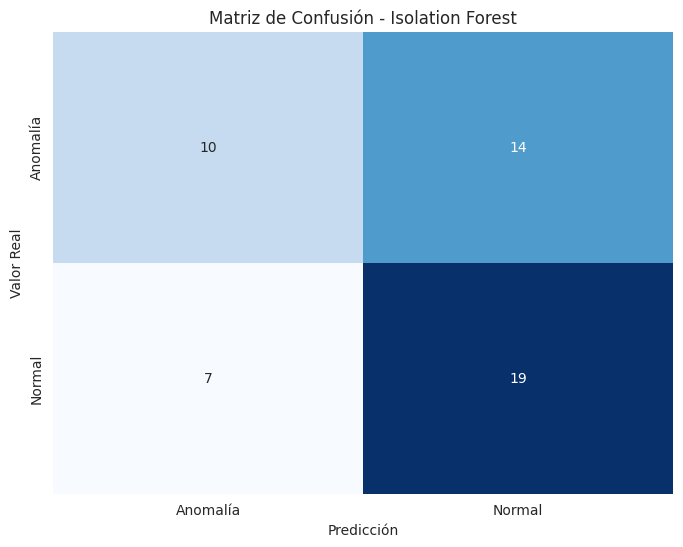

In [11]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Crear y ajustar el modelo Isolation Forest en todo el conjunto de datos
iforest = IsolationForest(random_state=42)
iforest.fit(X)

# Predecir las etiquetas para todo el conjunto de datos
predictions = iforest.predict(X)
predictions = [0 if x == -1 else 1 for x in predictions]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, predictions)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
plt.title('Matriz de Confusión - Isolation Forest')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


In [12]:
#SVM (Máquina de Vectores de Soporte)
#sirve para clasificar datos en dos categorías, pero también puede ser utilizada para detectar anomalías en datos no etiquetados,
#es decir, datos que no tienen una etiqueta de clase asociada. En este caso, la SVM se entrena para encontrar un límite de decisión
#que separe los datos normales de los datos anómalos en un espacio de alta dimensión.
#es un algoritmo de aprendizaje supervisado que se puede utilizar para clasificación y regresión.

import pandas as pd
import time
import psutil
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Crear una lista para almacenar los resultados
results = []

# Evaluar el modelo con diferentes fracciones del conjunto de datos
fractions = [0.2, 0.5, 0.8, 1.0]
for fraction in fractions:
    # Seleccionar una fracción del conjunto de datos
    X_frac = X.sample(frac=fraction, random_state=42)
    y_frac = y[X_frac.index]
    
    # Crear y ajustar el modelo One-Class SVM
    oc_svm = OneClassSVM(kernel='rbf', gamma='auto')
    start_training_time = time.time()
    oc_svm.fit(X_frac)
    training_time = time.time() - start_training_time
    
    # Obtener predicciones para la fracción del conjunto de datos
    start_execution_time = time.time()
    predictions = oc_svm.predict(X_frac)
    execution_time = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    predictions = [0 if x == -1 else 1 for x in predictions]
    
    # Calcular las métricas de evaluación
    precision = precision_score(y_frac, predictions, zero_division=0)
    recall = recall_score(y_frac, predictions, zero_division=0)
    f1 = f1_score(y_frac, predictions, zero_division=0)
    accuracy = accuracy_score(y_frac, predictions)
    
    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()
    
    # Almacenar los resultados
    results.append({
        'fraction': fraction,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'training_time': training_time,
        'execution_time': execution_time,
        'cpu_usage': cpu_usage,
        'memory_rss': memory_info.rss / 1024 ** 2,
        'memory_vms': memory_info.vms / 1024 ** 2
    })

# Imprimir resultados
print("Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:")
for result in results:
    print(f"Fracción del conjunto de datos: {result['fraction']:.2f}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print(f"Uso de CPU: {result['cpu_usage']:.2f}%")
    print(f"Uso de Memoria (RSS): {result['memory_rss']:.2f} MB")
    print(f"Uso de Memoria (VMS): {result['memory_vms']:.2f} MB")
    print("-" * 30)


Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:
Fracción del conjunto de datos: 0.20
Precisión: 0.00
Recall: 0.00
F1-score: 0.00
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.01 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 5.80%
Uso de Memoria (RSS): 243.58 MB
Uso de Memoria (VMS): 1140.77 MB
------------------------------
Fracción del conjunto de datos: 0.50
Precisión: 0.00
Recall: 0.00
F1-score: 0.00
Exactitud (Accuracy): 0.52
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 9.50%
Uso de Memoria (RSS): 243.58 MB
Uso de Memoria (VMS): 1140.77 MB
------------------------------
Fracción del conjunto de datos: 0.80
Precisión: 0.60
Recall: 0.15
F1-score: 0.24
Exactitud (Accuracy): 0.53
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 2.60%
Uso de Memoria (RSS): 243.58 MB
Uso de Memoria (VMS): 1140.77 MB
------------------------------
Fracción del conjunto de datos: 1.00
Precisi

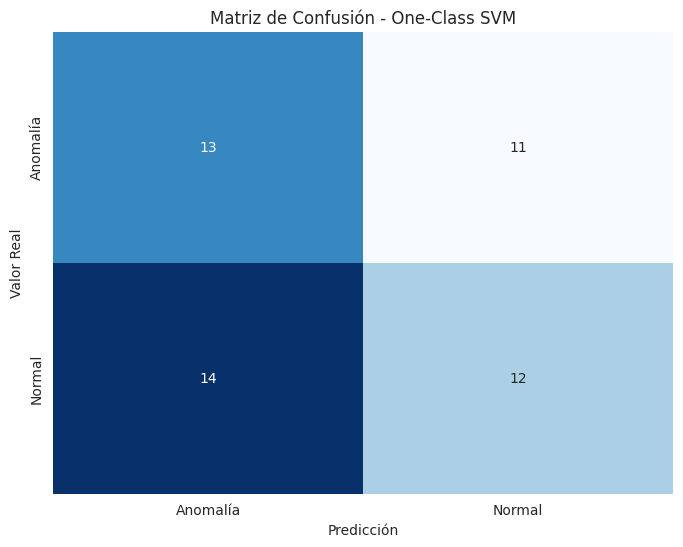

In [13]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Crear y ajustar el modelo One-Class SVM en todo el conjunto de datos
ocsvm = OneClassSVM(kernel='rbf', gamma='auto')
ocsvm.fit(X)

# Predecir las etiquetas para todo el conjunto de datos
predictions = ocsvm.predict(X)
predictions = [0 if x == -1 else 1 for x in predictions]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, predictions)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
plt.title('Matriz de Confusión - One-Class SVM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


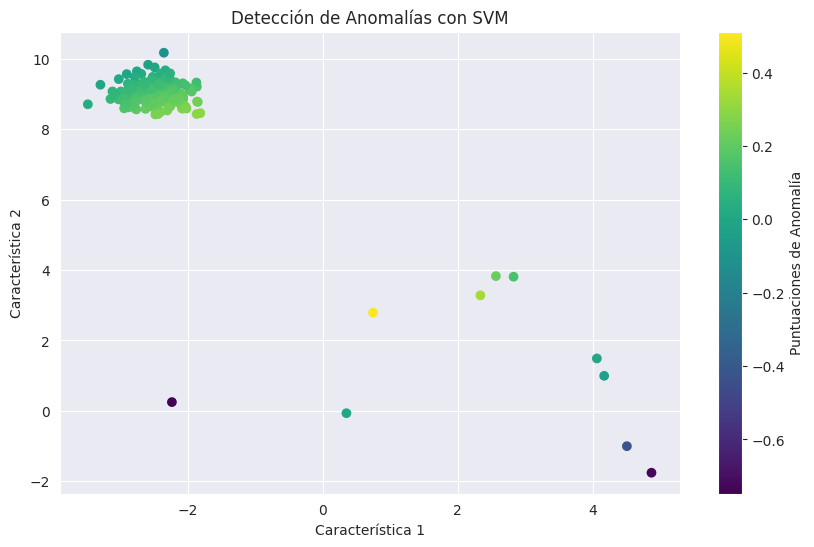

In [14]:
from sklearn.datasets import make_blobs  # librería para generar datos sintéticos
from sklearn.svm import OneClassSVM # librería para One-Class SVM
import matplotlib.pyplot as plt # librería para graficar datos
import numpy as np # librería para operaciones numéricas

# Generar datos sintéticos para demostración
X, _ = make_blobs(n_samples=200, centers=1, cluster_std=0.3, random_state=42)

# Introducir algunas anomalías
outliers = np.random.uniform(low=-5, high=5, size=(10, 2))
X = np.vstack([X, outliers])

# Ajustar el modelo One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm.fit(X)

# Obtener las puntuaciones de decisión/anomalía
svm_scores = svm.decision_function(X)

# Graficar las puntuaciones de anomalía
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=svm_scores, cmap='viridis')
plt.colorbar(label='Puntuaciones de Anomalía')
plt.title('Detección de Anomalías con SVM')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.grid(True)
plt.show()

#Los puntos más oscuros en el gráfico (colores más fríos en la barra de colores) representan las anomalías detectadas por el SVM, ya que tienen puntuaciones de anomalía más negativas.
#Los puntos más claros (colores más cálidos) son considerados menos anómalos según el modelo.


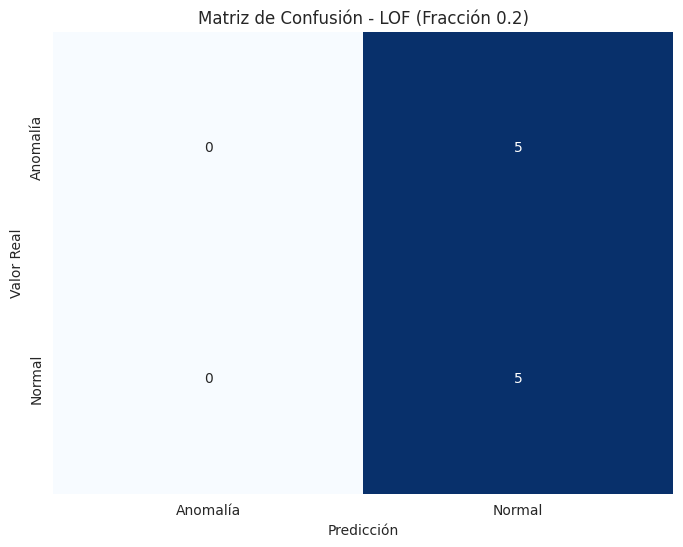

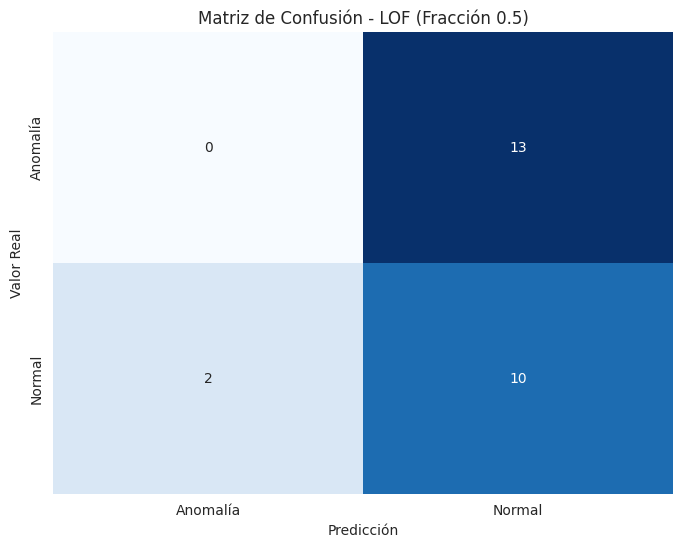

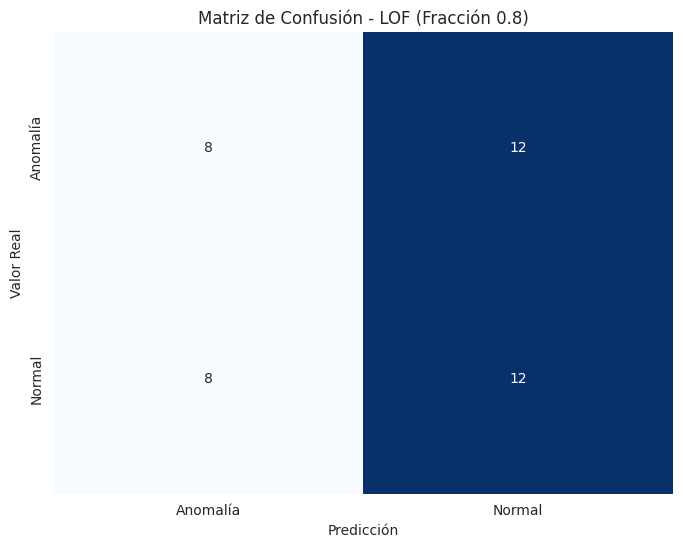

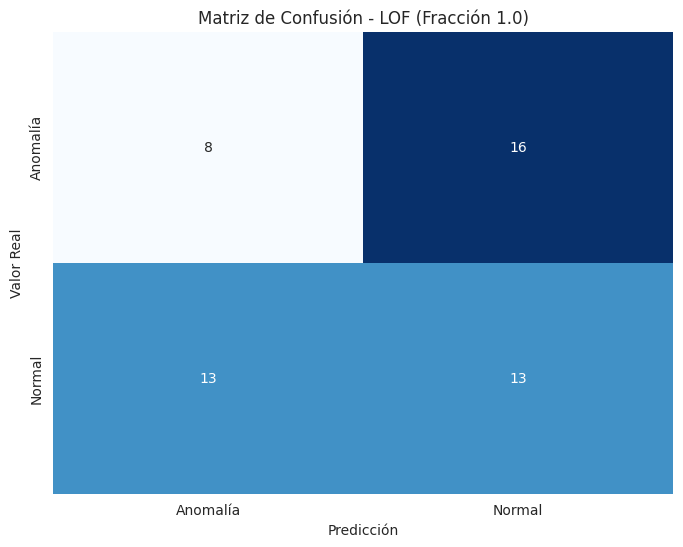

Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:
Fracción del conjunto de datos: 0.20
Precisión: 0.50
Recall: 1.00
F1-score: 0.67
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.04 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 5.80%
Uso de Memoria (RSS): 250.40 MB
Uso de Memoria (VMS): 1251.03 MB
------------------------------
Fracción del conjunto de datos: 0.50
Precisión: 0.43
Recall: 0.83
F1-score: 0.57
Exactitud (Accuracy): 0.40
Tiempo de entrenamiento: 0.30 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 4.00%
Uso de Memoria (RSS): 252.28 MB
Uso de Memoria (VMS): 1252.63 MB
------------------------------
Fracción del conjunto de datos: 0.80
Precisión: 0.50
Recall: 0.60
F1-score: 0.55
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 4.80%
Uso de Memoria (RSS): 254.15 MB
Uso de Memoria (VMS): 1254.29 MB
------------------------------
Fracción del conjunto de datos: 1.00
Precisi

In [15]:
#3.3 Resumen evaluacion LOF.
#LOF Factor de valor atípico local
#algoritmo de detección de anomalías que se basa en el concepto de densidad local
#para detectar las anomalías en los datos.
#es un algoritmo de aprendizaje no supervisado que se puede utilizar para detectar anomalías en datos no etiquetados,
#es decir, datos que no tienen una etiqueta de clase asociada.

import pandas as pd
import time
import psutil
import os
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import UndefinedMetricWarning

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Crear una lista para almacenar los resultados
results = []

# Función para evaluar LOF con manejo de advertencias
def evaluate_lof(X, y, fraction):
    # Seleccionar una fracción del conjunto de datos
    X_frac = X.sample(frac=fraction, random_state=42)
    y_frac = y[X_frac.index]
    
    # Ignorar las advertencias específicas sobre nombres de características
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="X does not have valid feature names")
        
        # Crear y ajustar el modelo LOF
        lof = LocalOutlierFactor(n_neighbors=min(20, len(X_frac) - 1), novelty=True)
        
        # Medir tiempo de entrenamiento
        start_training_time = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Ignorar todas las advertencias en ajuste y predicción
            lof.fit(X_frac)
        training_time = time.time() - start_training_time
        
        # Medir tiempo de ejecución
        start_execution_time = time.time()
        predictions = lof.predict(X_frac)
        execution_time = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    predictions = [1 if x == 1 else 0 for x in predictions]  # Convertir 1 a 0 y -1 a 1
    
    # Calcular las métricas de evaluación
    precision_lof1 = precision_score(y_frac, predictions, zero_division=0)
    recall_lof1 = recall_score(y_frac, predictions, zero_division=0)
    f1_lof1 = f1_score(y_frac, predictions, zero_division=0)
    accuracy_lof1 = accuracy_score(y_frac, predictions)
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_frac, predictions)
    
    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
                xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
    plt.title(f'Matriz de Confusión - LOF (Fracción {fraction})')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()
    
    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()
    
    # Almacenar los resultados
    results.append({
        'fraction': fraction,
        'precision': precision_lof1,
        'recall': recall_lof1,
        'f1_score': f1_lof1,
        'accuracy': accuracy_lof1,
        'training_time': training_time,
        'execution_time': execution_time,
        'cpu_usage': cpu_usage,
        'memory_rss': memory_info.rss / 1024 ** 2,
        'memory_vms': memory_info.vms / 1024 ** 2
    })

# Evaluar LOF para cada fracción
fractions = [0.2, 0.5, 0.8, 1.0]
for fraction in fractions:
    evaluate_lof(X, y, fraction)

# Imprimir resultados
print("Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:")
for result in results:
    print(f"Fracción del conjunto de datos: {result['fraction']:.2f}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print(f"Uso de CPU: {result['cpu_usage']:.2f}%")
    print(f"Uso de Memoria (RSS): {result['memory_rss']:.2f} MB")
    print(f"Uso de Memoria (VMS): {result['memory_vms']:.2f} MB")
    print("-" * 30)


In [16]:
#Metodologia topsis para seleccionar el mejor algoritmo

import pandas as pd
import time
import psutil
import os
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np
from sklearn.exceptions import UndefinedMetricWarning

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Crear una lista para almacenar los resultados
results = []

# Función para evaluar un modelo con manejo de advertencias
def evaluate_model(model, X, y, fraction):
    # Seleccionar una fracción del conjunto de datos
    X_frac = X.sample(frac=fraction, random_state=42)
    y_frac = y[X_frac.index]
    
    # Ajustar el modelo
    start_time = time.time()
    model.fit(X_frac)
    training_time = time.time() - start_time
    
    # Realizar predicciones
    predictions = model.predict(X_frac)
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    predictions = [1 if x == 1 else 0 for x in predictions]
    
    # Calcular las métricas de evaluación
    precision = precision_score(y_frac, predictions, zero_division=0)
    recall = recall_score(y_frac, predictions, zero_division=0)
    f1 = f1_score(y_frac, predictions, zero_division=0)
    accuracy = accuracy_score(y_frac, predictions)
    
    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()
    
    # Devolver los resultados
    return precision, recall, f1, accuracy, training_time, memory_info.rss / 1024 ** 2, memory_info.vms / 1024 ** 2

# Evaluar Isolation Forest
isolation_forest = IsolationForest()
precision_if, recall_if, f1_if, accuracy_if, training_time_if, rss_if, vms_if = evaluate_model(isolation_forest, X, y, 1.0)

# Evaluar One-Class SVM
one_class_svm = OneClassSVM()
precision_ocsvm, recall_ocsvm, f1_ocsvm, accuracy_ocsvm, training_time_ocsvm, rss_ocsvm, vms_ocsvm = evaluate_model(one_class_svm, X, y, 1.0)

# Evaluar LOF
lof = LocalOutlierFactor(n_neighbors=min(20, len(X) - 1), novelty=True)
precision_lof, recall_lof, f1_lof, accuracy_lof, training_time_lof, rss_lof, vms_lof = evaluate_model(lof, X, y, 1.0)

# Matriz de decisión (rows: algoritmos, columns: criterios)
decision_matrix = np.array([
    [precision_if, recall_if, f1_if, accuracy_if, training_time_if, rss_if, vms_if],  # Isolation Forest
    [precision_ocsvm, recall_ocsvm, f1_ocsvm, accuracy_ocsvm, training_time_ocsvm, rss_ocsvm, vms_ocsvm],  # One-Class SVM
    [precision_lof, recall_lof, f1_lof, accuracy_lof, training_time_lof, rss_lof, vms_lof]  # LOF
])

# Pesos para cada criterio (ajustados según importancia)
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.1, 0.05, 0.05])  # Ejemplo de pesos ajustados

# Normalizar la matriz de decisión
norm_matrix = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))

# Ponderar la matriz normalizada
weighted_matrix = norm_matrix * weights

# Identificar las soluciones ideal positiva y negativa
ideal_positive = weighted_matrix.max(axis=0)
ideal_negative = weighted_matrix.min(axis=0)

# Calcular las distancias a las soluciones ideal positiva y negativa
distance_positive = np.sqrt(((weighted_matrix - ideal_positive) ** 2).sum(axis=1))
distance_negative = np.sqrt(((weighted_matrix - ideal_negative) ** 2).sum(axis=1))

# Calcular el puntaje de preferencia
preference_scores = distance_negative / (distance_positive + distance_negative)

# Determinar el mejor algoritmo basado en el puntaje de preferencia
best_algorithm_index = preference_scores.argmax()
algorithms = ['Isolation Forest', 'One-Class SVM', 'LOF']

# Mostrar los resultados
for i, algorithm in enumerate(algorithms):
    print(f"{algorithm}:")
    print(f"  Precisión: {decision_matrix[i, 0]:.2f}")
    print(f"  Recall: {decision_matrix[i, 1]:.2f}")
    print(f"  F1-score: {decision_matrix[i, 2]:.2f}")
    print(f"  Exactitud (Accuracy): {decision_matrix[i, 3]:.2f}")
    print(f"  Tiempo de Entrenamiento: {decision_matrix[i, 4]:.2f} segundos")
    print(f"  Uso de Memoria (RSS): {decision_matrix[i, 5]:.2f} MB")
    print(f"  Uso de Memoria (VMS): {decision_matrix[i, 6]:.2f} MB")
    print(f"  Puntaje de Preferencia: {preference_scores[i]:.4f}")
    print()

print("Puntajes de preferencia:", preference_scores)
print("Mejor algoritmo según TOPSIS:", algorithms[best_algorithm_index])

#Insolation Forest esta indicando que es la alternativa más cercana a la solución ideal positiva y más lejana de la solución ideal negativa en comparación con los otros algoritmos


/home/kali/.virtualenvs/pythonProject/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Isolation Forest:
  Precisión: 0.56
  Recall: 0.73
  F1-score: 0.63
  Exactitud (Accuracy): 0.56
  Tiempo de Entrenamiento: 0.17 segundos
  Uso de Memoria (RSS): 254.78 MB
  Uso de Memoria (VMS): 1255.29 MB
  Puntaje de Preferencia: 0.9999

One-Class SVM:
  Precisión: 0.48
  Recall: 0.46
  F1-score: 0.47
  Exactitud (Accuracy): 0.46
  Tiempo de Entrenamiento: 0.01 segundos
  Uso de Memoria (RSS): 254.90 MB
  Uso de Memoria (VMS): 1255.29 MB
  Puntaje de Preferencia: 0.0929

LOF:
  Precisión: 0.45
  Recall: 0.50
  F1-score: 0.47
  Exactitud (Accuracy): 0.42
  Tiempo de Entrenamiento: 0.00 segundos
  Uso de Memoria (RSS): 254.90 MB
  Uso de Memoria (VMS): 1255.29 MB
  Puntaje de Preferencia: 0.0598

Puntajes de preferencia: [0.99988643 0.09294404 0.05977799]
Mejor algoritmo según TOPSIS: Isolation Forest


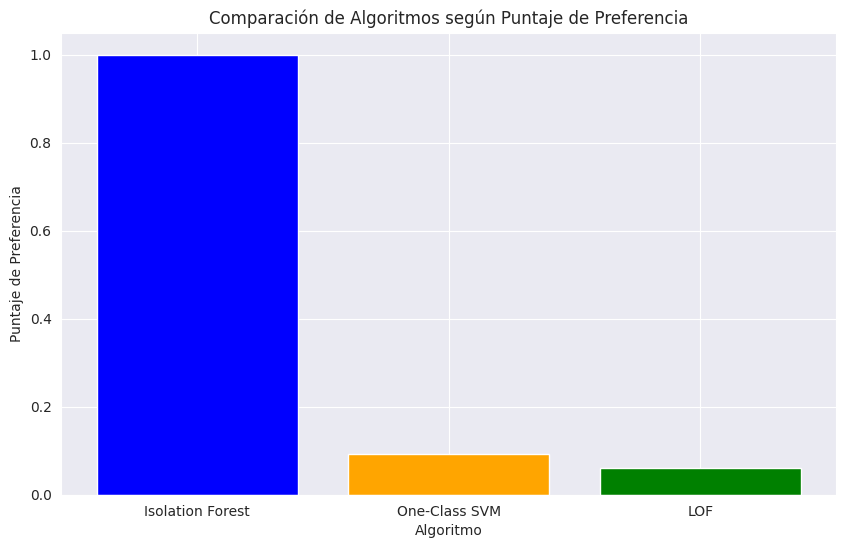

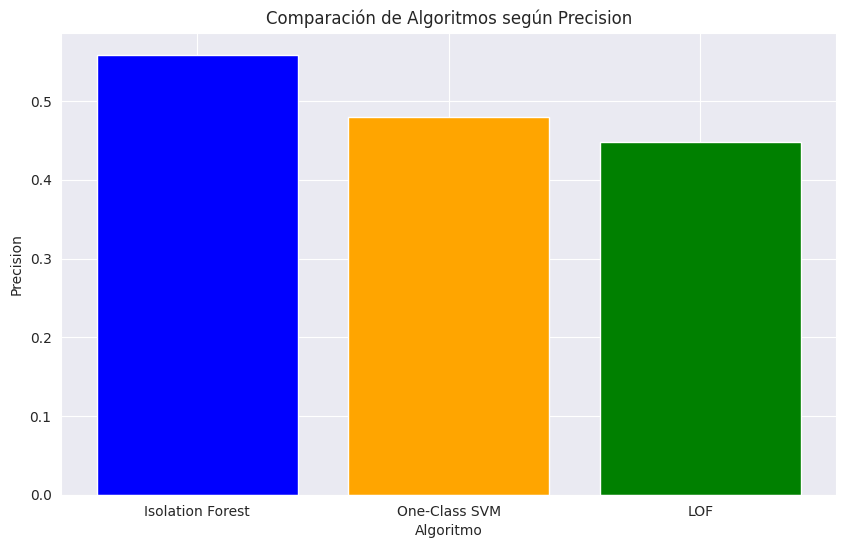

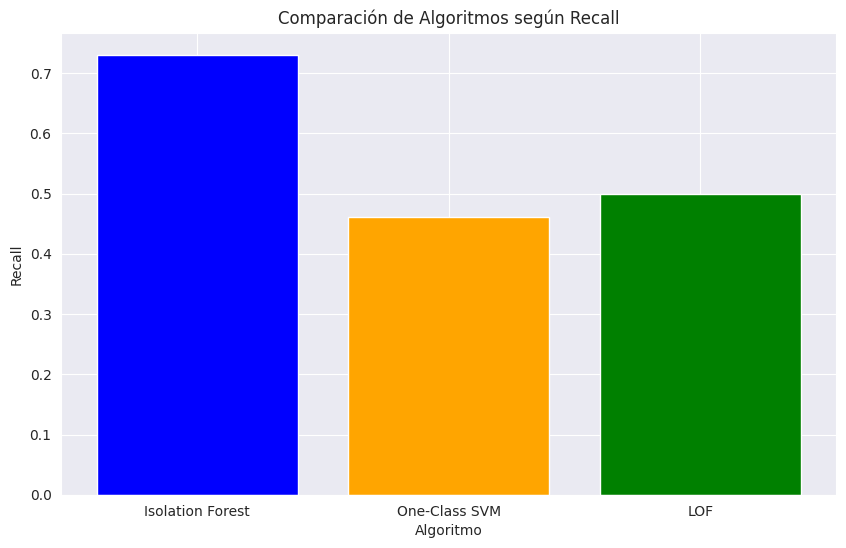

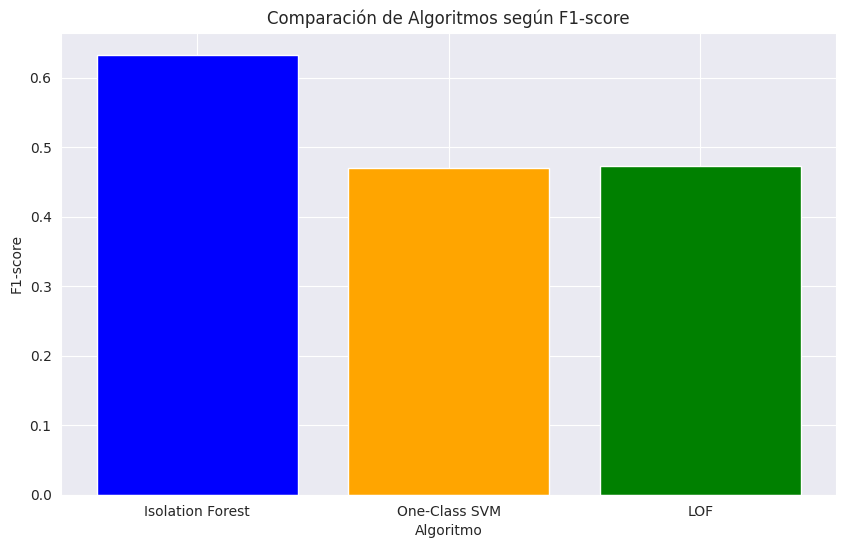

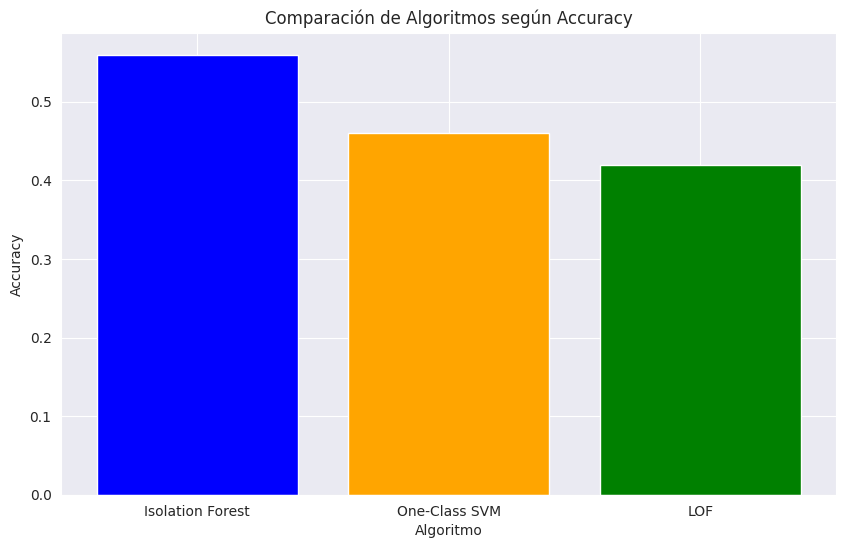

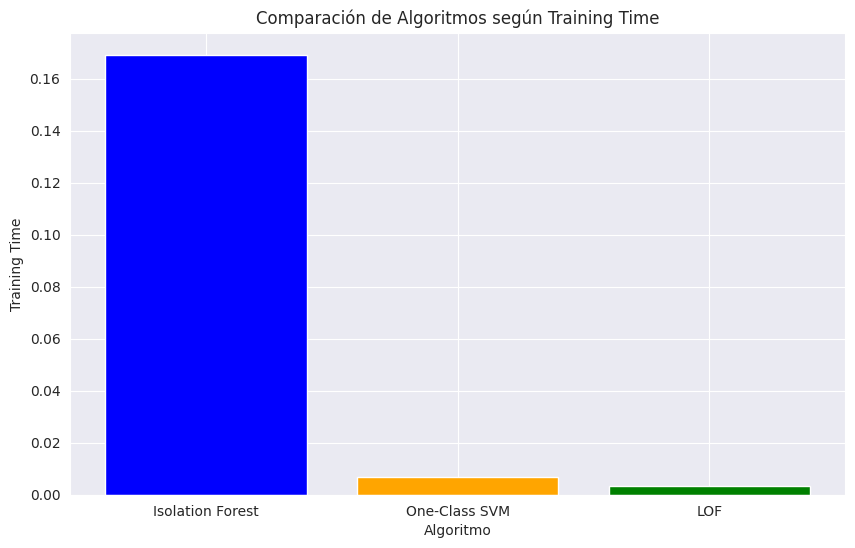

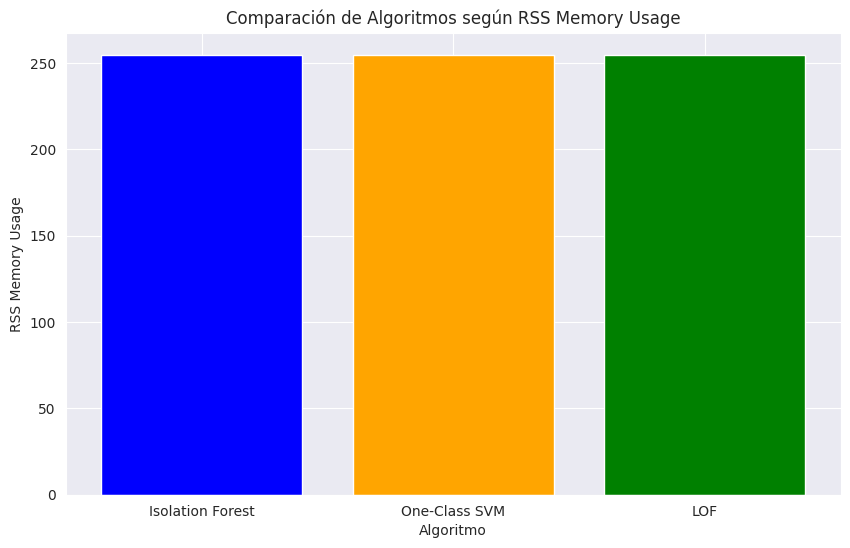

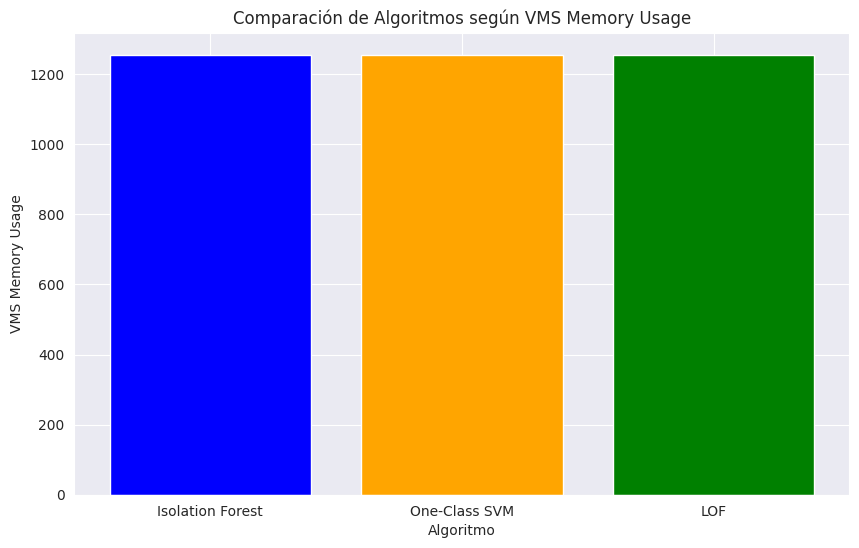

In [17]:
#grafica de barras para los puntajes de preferencia de los algoritmos

import matplotlib.pyplot as plt

# Crear un DataFrame para los resultados
results_df = pd.DataFrame({
    'Algoritmo': ['Isolation Forest', 'One-Class SVM', 'LOF'],
    'Precision': [precision_if, precision_ocsvm, precision_lof],
    'Recall': [recall_if, recall_ocsvm, recall_lof],
    'F1-score': [f1_if, f1_ocsvm, f1_lof],
    'Accuracy': [accuracy_if, accuracy_ocsvm, accuracy_lof],
    'Training Time': [training_time_if, training_time_ocsvm, training_time_lof],
    'RSS Memory Usage': [rss_if, rss_ocsvm, rss_lof],
    'VMS Memory Usage': [vms_if, vms_ocsvm, vms_lof],
    'Puntaje de Preferencia': preference_scores
})

# Crear un gráfico de barras para los puntajes de preferencia
plt.figure(figsize=(10, 6))
plt.bar(results_df['Algoritmo'], results_df['Puntaje de Preferencia'], color=['blue', 'orange', 'green'])
plt.xlabel('Algoritmo')
plt.ylabel('Puntaje de Preferencia')
plt.title('Comparación de Algoritmos según Puntaje de Preferencia')
plt.show()

# Crear gráficos de barras para cada criterio
criteria = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'Training Time', 'RSS Memory Usage', 'VMS Memory Usage']

for criterion in criteria:
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['Algoritmo'], results_df[criterion], color=['blue', 'orange', 'green'])
    plt.xlabel('Algoritmo')
    plt.ylabel(criterion)
    plt.title(f'Comparación de Algoritmos según {criterion}')
    plt.show()
